# Reward distributions

In [1]:
from huggingface_hub import hf_hub_download, HfApi
from plotnine import ggplot, aes, geom_density
from skopt import load
from stable_baselines3 import PPO

from rl4fisheries import AsmEnv, Msy, ConstEsc, CautionaryRule
from rl4fisheries.utils import evaluate_agent
from rl4fisheries.envs.asm_fns import get_r_devs

import numpy as np
import pandas as pd
import ray

In [2]:
## UM1

CFG_UM1_2o = {
    'observation_fn_id': 'observe_2o',
    'n_observs': 2,
    #
    'harvest_fn_name': "default",
    'upow': 1,
}
CFG_UM1_mw = {
    'observation_fn_id': 'observe_mwt',
    'n_observs': 1,
    #
    'harvest_fn_name': "default",
    'upow': 1,
}
CFG_UM1_bm = {
    'observation_fn_id': 'observe_1o',
    'n_observs': 1,
    #
    'harvest_fn_name': "default",
    'upow': 1,
}

## UM2

CFG_UM2_2o = {
    'observation_fn_id': 'observe_2o',
    'n_observs': 2,
    #
    'harvest_fn_name': "default",
    'upow': 0.6,
}
CFG_UM2_mw = {
    'observation_fn_id': 'observe_mwt',
    'n_observs': 1,
    #
    'harvest_fn_name': "default",
    'upow': 0.6,
}
CFG_UM2_bm = {
    'observation_fn_id': 'observe_1o',
    'n_observs': 1,
    #
    'harvest_fn_name': "default",
    'upow': 0.6,
}

## UM3

CFG_UM3_2o = {
    'observation_fn_id': 'observe_2o',
    'n_observs': 2,
    #
    'harvest_fn_name': "trophy",
    'upow': 1,
    'n_trophy_ages': 10
}
CFG_UM3_mw = {
    'observation_fn_id': 'observe_mwt',
    'n_observs': 1,
    #
    'harvest_fn_name': "trophy",
    'upow': 1,
    'n_trophy_ages': 10
}
CFG_UM3_bm = {
    'observation_fn_id': 'observe_1o',
    'n_observs': 1,
    #
    'harvest_fn_name': "trophy",
    'upow': 1,
    'n_trophy_ages': 10
}

## Load

In [3]:
cr_UM1_file = hf_hub_download(repo_id="boettiger-lab/rl4eco", filename="sb3/rl4fisheries/results/cr-UM1.pkl")
cr_UM2_file = hf_hub_download(repo_id="boettiger-lab/rl4eco", filename="sb3/rl4fisheries/results/cr-UM2.pkl")
cr_UM3_file = hf_hub_download(repo_id="boettiger-lab/rl4eco", filename="sb3/rl4fisheries/results/cr-UM3.pkl")

esc_UM1_file = hf_hub_download(repo_id="boettiger-lab/rl4eco", filename="sb3/rl4fisheries/results/esc-UM1.pkl")
esc_UM2_file = hf_hub_download(repo_id="boettiger-lab/rl4eco", filename="sb3/rl4fisheries/results/esc-UM2.pkl")
esc_UM3_file = hf_hub_download(repo_id="boettiger-lab/rl4eco", filename="sb3/rl4fisheries/results/esc-UM3.pkl")

msy_UM1_file = hf_hub_download(repo_id="boettiger-lab/rl4eco", filename="sb3/rl4fisheries/results/msy-UM1.pkl")
msy_UM2_file = hf_hub_download(repo_id="boettiger-lab/rl4eco", filename="sb3/rl4fisheries/results/msy-UM2.pkl")
msy_UM3_file = hf_hub_download(repo_id="boettiger-lab/rl4eco", filename="sb3/rl4fisheries/results/msy-UM3.pkl")

In [4]:
cr_UM1 = load(cr_UM1_file)
cr_UM2 = load(cr_UM2_file)
cr_UM3 = load(cr_UM3_file)

esc_UM1 = load(esc_UM1_file)
esc_UM2 = load(esc_UM2_file)
esc_UM3 = load(esc_UM3_file)

msy_UM1 = load(msy_UM1_file)
msy_UM2 = load(msy_UM2_file)
msy_UM3 = load(msy_UM3_file)

In [5]:
base_fname = "sb3/rl4fisheries/results/PPO-AsmEnv-"
repo = "boettiger-lab/rl4eco"

PPO_2o_UM1_file = hf_hub_download(repo_id=repo, filename=base_fname+"2obs-UM1-64-32-16-chkpnt4.zip")
PPO_mw_UM1_file = hf_hub_download(repo_id=repo, filename=base_fname+"mwt-UM1-64-32-16-chkpnt4.zip")
PPO_bm_UM1_file = hf_hub_download(repo_id=repo, filename=base_fname+"biomass-UM1-64-32-16-chkpnt3.zip")

PPO_2o_UM2_file = hf_hub_download(repo_id=repo, filename=base_fname+"2obs-UM2-64-32-16-chkpnt4.zip")
PPO_mw_UM2_file = hf_hub_download(repo_id=repo, filename=base_fname+"mwt-UM2-64-32-16-chkpnt2.zip")
PPO_bm_UM2_file = hf_hub_download(repo_id=repo, filename=base_fname+"biomass-UM2-64-32-16-chkpnt2.zip")

PPO_2o_UM3_file = hf_hub_download(repo_id=repo, filename=base_fname+"2obs-UM3-64-32-16-chkpnt4.zip")
PPO_mw_UM3_file = hf_hub_download(repo_id=repo, filename=base_fname+"mwt-UM3-64-32-16-chkpnt4.zip")
PPO_bm_UM3_file = hf_hub_download(repo_id=repo, filename=base_fname+"biomass-UM3-64-32-16-chkpnt3.zip")

In [6]:
PPO_2o_UM1 = PPO.load(PPO_2o_UM1_file, device='cpu')
PPO_mw_UM1 = PPO.load(PPO_mw_UM1_file, device='cpu')
PPO_bm_UM1 = PPO.load(PPO_bm_UM1_file, device='cpu')

PPO_2o_UM2 = PPO.load(PPO_2o_UM2_file, device='cpu')
PPO_mw_UM2 = PPO.load(PPO_mw_UM2_file, device='cpu')
PPO_bm_UM2 = PPO.load(PPO_bm_UM2_file, device='cpu')

PPO_2o_UM3 = PPO.load(PPO_2o_UM3_file, device='cpu')
PPO_mw_UM3 = PPO.load(PPO_mw_UM3_file, device='cpu')
PPO_bm_UM3 = PPO.load(PPO_bm_UM3_file, device='cpu')

## Reward Plots

In [7]:
def get_rews(agent, env, agent_name):
    rewards = evaluate_agent(
        agent=agent, env=env, ray_remote=True,
    ).evaluate(
        return_episode_rewards=True, n_eval_episodes=500,
    )
    return {'rew': rewards, 'agent': [agent_name] * len(rewards)}

In [8]:
def from_radius_theta(radius, theta, y2):
    x1 = radius * np.sin(theta)
    x2 = radius * np.cos(theta)
    return {'x1': x1, 'x2': x2, 'y2': y2}

### UM1

In [9]:
PPO_2o_rews = get_rews(
    agent=PPO_2o_UM1,
    env=AsmEnv(config=CFG_UM1_2o),
    agent_name='PPO_2o',
)

PPO_mw_rews = get_rews(
    agent=PPO_mw_UM1,
    env=AsmEnv(config=CFG_UM1_mw),
    agent_name='PPO_mw',
)

PPO_bm_rews = get_rews(
    agent=PPO_bm_UM1,
    env=AsmEnv(config=CFG_UM1_bm),
    agent_name='PPO_bm',
)


2024-06-18 21:26:17,758	INFO worker.py:1749 -- Started a local Ray instance.
2024-06-18 21:26:34,543	INFO worker.py:1749 -- Started a local Ray instance.
2024-06-18 21:26:50,957	INFO worker.py:1749 -- Started a local Ray instance.


In [10]:
CR_rews = get_rews(
    agent=CautionaryRule(
        env=AsmEnv(config=CFG_UM1_bm),
        **(from_radius_theta(*cr_UM1.x)),
    ),
    env=AsmEnv(config=CFG_UM1_bm),
    agent_name='CR',
)

Esc_rews = get_rews(
    agent=ConstEsc(
        escapement=esc_UM1.x[0],
        env=AsmEnv(config=CFG_UM1_bm),
    ),
    agent_name='Esc',
    env=AsmEnv(config=CFG_UM1_bm),
)

Msy_rews = get_rews(
    agent=Msy(
        mortality=msy_UM1.x[0],
        env=AsmEnv(config=CFG_UM1_bm),
    ),
    agent_name='Msy',
    env=AsmEnv(config=CFG_UM1_bm),
)

2024-06-18 21:27:07,845	INFO worker.py:1749 -- Started a local Ray instance.
2024-06-18 21:27:16,526	INFO worker.py:1749 -- Started a local Ray instance.
2024-06-18 21:27:26,348	INFO worker.py:1749 -- Started a local Ray instance.


In [11]:
ray.shutdown()

In [12]:
fixed_pol_df = pd.concat(
    [
        pd.DataFrame(CR_rews),
        pd.DataFrame(Esc_rews),
        pd.DataFrame(Msy_rews),
    ]
)
ppo_df = pd.concat(
    [
        pd.DataFrame(PPO_2o_rews),
        pd.DataFrame(PPO_mw_rews),
        pd.DataFrame(PPO_bm_rews),
    ]
)

results_df = pd.concat(
    [pd.DataFrame(CR_rews), pd.DataFrame(Msy_rews),  pd.DataFrame(PPO_2o_rews), pd.DataFrame(PPO_bm_rews)]
)

In [13]:
print(f"""
UM1:

        mean stdev median
CR:   {np.mean(CR_rews['rew']):.2f}, {np.std(CR_rews['rew']):.2f}, {np.median(CR_rews['rew']):.2f}, 
Esc:  {np.mean(Esc_rews['rew']):.2f}, {np.std(Esc_rews['rew']):.2f}, {np.median(Esc_rews['rew']):.2f}, 
Eff:  {np.mean(Msy_rews['rew']):.2f}, {np.std(Msy_rews['rew']):.2f}, {np.median(Msy_rews['rew']):.2f}, 
PPO2: {np.mean(PPO_2o_rews['rew']):.2f}, {np.std(PPO_2o_rews['rew']):.2f}, {np.median(PPO_2o_rews['rew']):.2f},
PPO1: {np.mean(PPO_bm_rews['rew']):.2f}, {np.std(PPO_bm_rews['rew']):.2f}, {np.median(PPO_bm_rews['rew']):.2f},
""")


UM1:

        mean stdev median
CR:   105.70, 22.27, 104.92, 
Esc:  105.09, 21.17, 103.86, 
Eff:  71.73, 17.70, 70.63, 
PPO1: 95.81, 19.23, 95.07,
PPO2: 98.32, 17.65, 97.32,



/opt/venv/lib/python3.10/site-packages/IPython/lib/pretty.py:778: FutureWarning: Using repr(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


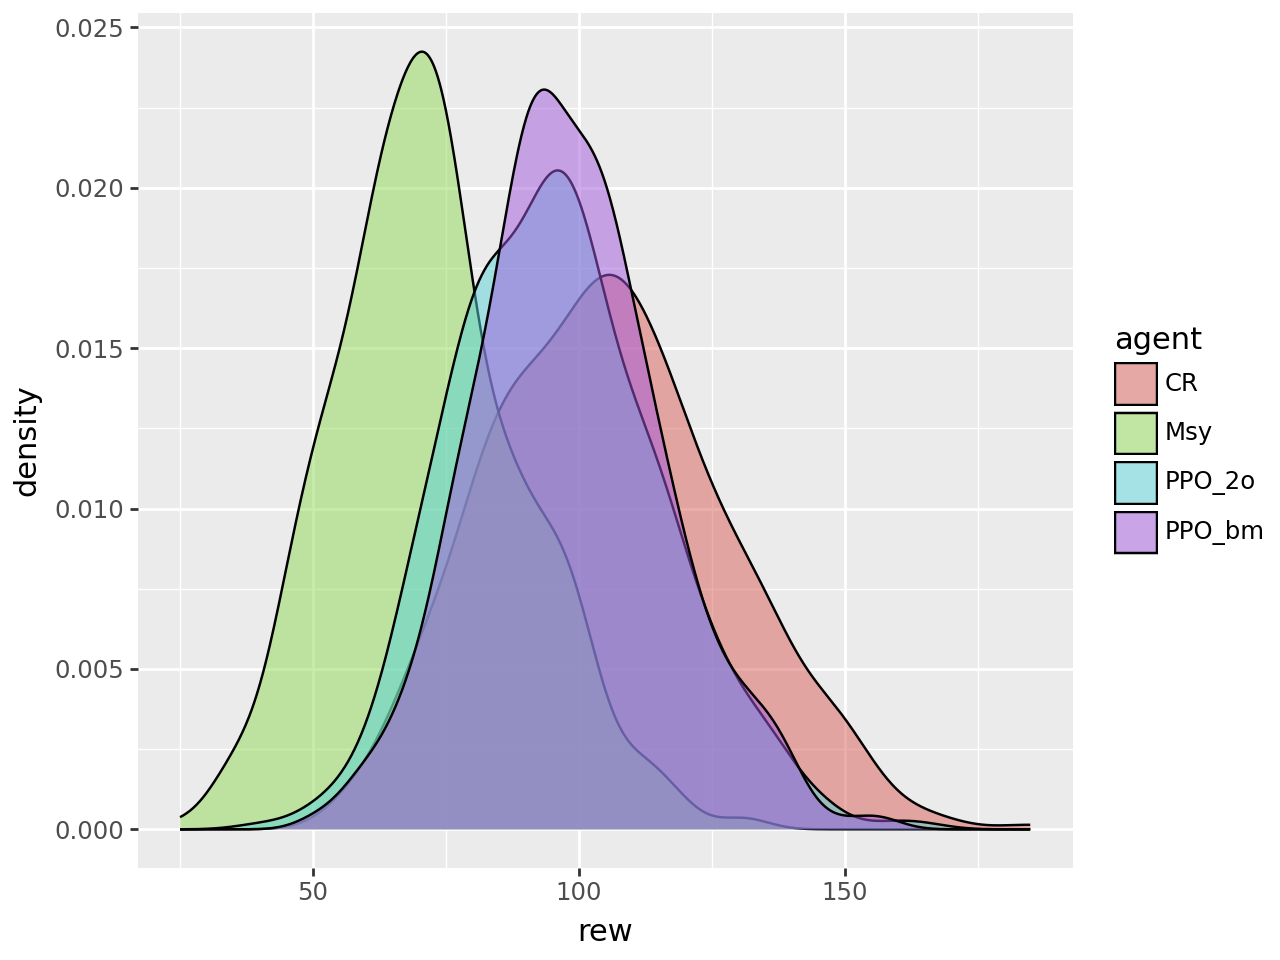

(<Figure Size: (640 x 480)>,)

In [14]:
(
    # ggplot(fixed_pol_df, aes(x='rew', fill='agent')) + geom_density(alpha=0.5),
    # ggplot(ppo_df, aes(x='rew', fill='agent')) + geom_density(alpha=0.5),
    ggplot(results_df, aes(x='rew', fill='agent')) + geom_density(alpha=0.5),
)

### UM2

In [15]:
PPO_2o_rews = get_rews(
    agent=PPO_2o_UM2,
    env=AsmEnv(config=CFG_UM2_2o),
    agent_name='PPO_2o',
)

PPO_mw_rews = get_rews(
    agent=PPO_mw_UM2,
    env=AsmEnv(config=CFG_UM2_mw),
    agent_name='PPO_mw',
)

PPO_bm_rews = get_rews(
    agent=PPO_bm_UM2,
    env=AsmEnv(config=CFG_UM2_bm),
    agent_name='PPO_bm',
)


2024-06-18 21:33:39,617	INFO worker.py:1749 -- Started a local Ray instance.
2024-06-18 21:33:56,468	INFO worker.py:1749 -- Started a local Ray instance.
2024-06-18 21:34:13,011	INFO worker.py:1749 -- Started a local Ray instance.


In [16]:
CR_rews = get_rews(
    agent=CautionaryRule(
        env=AsmEnv(config=CFG_UM2_bm),
        **(from_radius_theta(*cr_UM2.x)),
    ),
    env=AsmEnv(config=CFG_UM2_bm),
    agent_name='CR',
)

Esc_rews = get_rews(
    agent=ConstEsc(
        escapement=esc_UM2.x[0],
        env=AsmEnv(config=CFG_UM2_bm),
    ),
    agent_name='Esc',
    env=AsmEnv(config=CFG_UM2_bm),
)

Msy_rews = get_rews(
    agent=Msy(
        mortality=msy_UM2.x[0],
        env=AsmEnv(config=CFG_UM2_bm),
    ),
    agent_name='Msy',
    env=AsmEnv(config=CFG_UM2_bm),
)

2024-06-18 21:34:29,786	INFO worker.py:1749 -- Started a local Ray instance.
2024-06-18 21:34:38,508	INFO worker.py:1749 -- Started a local Ray instance.
2024-06-18 21:34:48,193	INFO worker.py:1749 -- Started a local Ray instance.


In [17]:
fixed_pol_df = pd.concat(
    [
        pd.DataFrame(CR_rews),
        pd.DataFrame(Esc_rews),
        pd.DataFrame(Msy_rews),
    ]
)
ppo_df = pd.concat(
    [
        pd.DataFrame(PPO_2o_rews),
        pd.DataFrame(PPO_mw_rews),
        pd.DataFrame(PPO_bm_rews),
    ]
)

results_df = pd.concat(
    [pd.DataFrame(CR_rews), pd.DataFrame(Msy_rews),  pd.DataFrame(PPO_2o_rews), pd.DataFrame(PPO_bm_rews)]
)

In [18]:
print(f"""
UM1:

        mean stdev median
CR:   {np.mean(CR_rews['rew']):.2f}, {np.std(CR_rews['rew']):.2f}, {np.median(CR_rews['rew']):.2f}, 
Esc:  {np.mean(Esc_rews['rew']):.2f}, {np.std(Esc_rews['rew']):.2f}, {np.median(Esc_rews['rew']):.2f}, 
Eff:  {np.mean(Msy_rews['rew']):.2f}, {np.std(Msy_rews['rew']):.2f}, {np.median(Msy_rews['rew']):.2f}, 
PPO2: {np.mean(PPO_2o_rews['rew']):.2f}, {np.std(PPO_2o_rews['rew']):.2f}, {np.median(PPO_2o_rews['rew']):.2f},
PPO1: {np.mean(PPO_bm_rews['rew']):.2f}, {np.std(PPO_bm_rews['rew']):.2f}, {np.median(PPO_bm_rews['rew']):.2f},
""")


UM1:

        mean stdev median
CR:   189.39, 27.52, 188.97, 
Esc:  138.51, 24.97, 137.33, 
Eff:  173.77, 26.18, 172.70, 
PPO1: 135.00, 17.62, 134.79,
PPO2: 189.84, 25.84, 189.26,



/opt/venv/lib/python3.10/site-packages/IPython/lib/pretty.py:778: FutureWarning: Using repr(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


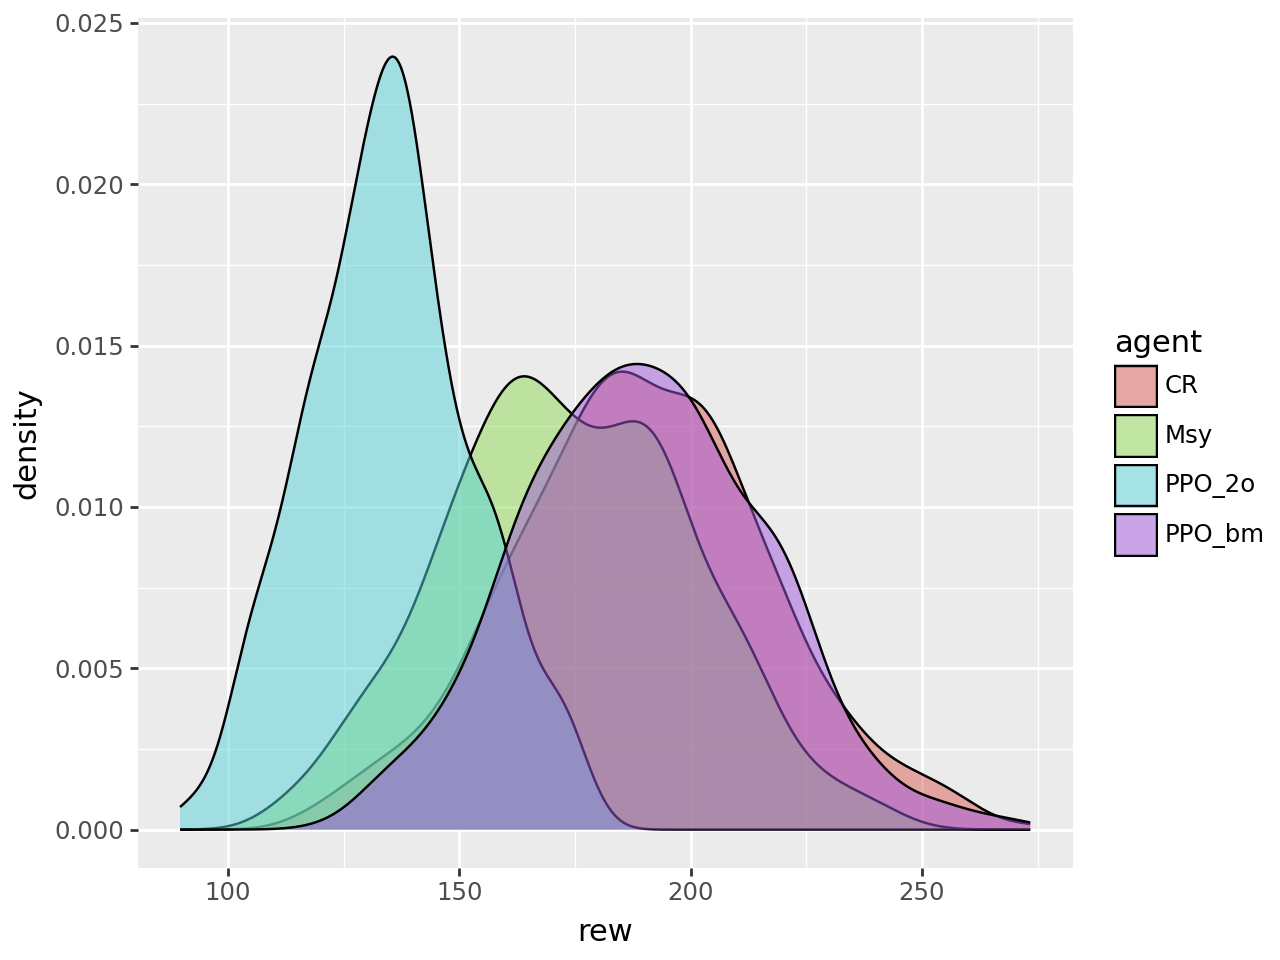

(<Figure Size: (640 x 480)>,)

In [19]:
(
    # ggplot(fixed_pol_df, aes(x='rew', fill='agent')) + geom_density(alpha=0.5),
    # ggplot(ppo_df, aes(x='rew', fill='agent')) + geom_density(alpha=0.5),
    ggplot(results_df, aes(x='rew', fill='agent')) + geom_density(alpha=0.5),
)

### UM3

In [20]:
PPO_2o_rews = get_rews(
    agent=PPO_2o_UM3,
    env=AsmEnv(config=CFG_UM3_2o),
    agent_name='PPO_2o',
)

PPO_mw_rews = get_rews(
    agent=PPO_mw_UM3,
    env=AsmEnv(config=CFG_UM3_mw),
    agent_name='PPO_mw',
)

PPO_bm_rews = get_rews(
    agent=PPO_bm_UM3,
    env=AsmEnv(config=CFG_UM3_bm),
    agent_name='PPO_bm',
)


2024-06-18 21:41:46,166	INFO worker.py:1749 -- Started a local Ray instance.
2024-06-18 21:42:02,794	INFO worker.py:1749 -- Started a local Ray instance.
2024-06-18 21:42:19,454	INFO worker.py:1749 -- Started a local Ray instance.


In [21]:
CR_rews = get_rews(
    agent=CautionaryRule(
        env=AsmEnv(config=CFG_UM3_bm),
        **(from_radius_theta(*cr_UM3.x)),
    ),
    env=AsmEnv(config=CFG_UM3_bm),
    agent_name='CR',
)

Esc_rews = get_rews(
    agent=ConstEsc(
        escapement=esc_UM3.x[0],
        env=AsmEnv(config=CFG_UM3_bm),
    ),
    agent_name='Esc',
    env=AsmEnv(config=CFG_UM3_bm),
)

Msy_rews = get_rews(
    agent=Msy(
        mortality=msy_UM3.x[0],
        env=AsmEnv(config=CFG_UM3_bm),
    ),
    agent_name='Msy',
    env=AsmEnv(config=CFG_UM3_bm),
)

2024-06-18 21:42:36,178	INFO worker.py:1749 -- Started a local Ray instance.
2024-06-18 21:42:45,800	INFO worker.py:1749 -- Started a local Ray instance.
2024-06-18 21:42:54,685	INFO worker.py:1749 -- Started a local Ray instance.


In [22]:
fixed_pol_df = pd.concat(
    [
        pd.DataFrame(CR_rews),
        pd.DataFrame(Esc_rews),
        pd.DataFrame(Msy_rews),
    ]
)
ppo_df = pd.concat(
    [
        pd.DataFrame(PPO_2o_rews),
        pd.DataFrame(PPO_mw_rews),
        pd.DataFrame(PPO_bm_rews),
    ]
)

results_df = pd.concat(
    [pd.DataFrame(CR_rews), pd.DataFrame(Msy_rews),  pd.DataFrame(PPO_2o_rews), pd.DataFrame(PPO_bm_rews)]
)

In [23]:
print(f"""
UM1:

        mean stdev median
CR:   {np.mean(CR_rews['rew']):.2f}, {np.std(CR_rews['rew']):.2f}, {np.median(CR_rews['rew']):.2f}, 
Esc:  {np.mean(Esc_rews['rew']):.2f}, {np.std(Esc_rews['rew']):.2f}, {np.median(Esc_rews['rew']):.2f}, 
Eff:  {np.mean(Msy_rews['rew']):.2f}, {np.std(Msy_rews['rew']):.2f}, {np.median(Msy_rews['rew']):.2f}, 
PPO1: {np.mean(PPO_2o_rews['rew']):.2f}, {np.std(PPO_2o_rews['rew']):.2f}, {np.median(PPO_2o_rews['rew']):.2f},
PPO2: {np.mean(PPO_bm_rews['rew']):.2f}, {np.std(PPO_bm_rews['rew']):.2f}, {np.median(PPO_bm_rews['rew']):.2f},
""")


UM1:

        mean stdev median
CR:   39.18, 8.38, 38.07, 
Esc:  17.54, 4.61, 17.23, 
Eff:  35.31, 7.62, 34.68, 
PPO1: 78.65, 14.01, 79.00,
PPO2: 36.13, 6.85, 35.89,



/opt/venv/lib/python3.10/site-packages/IPython/lib/pretty.py:778: FutureWarning: Using repr(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


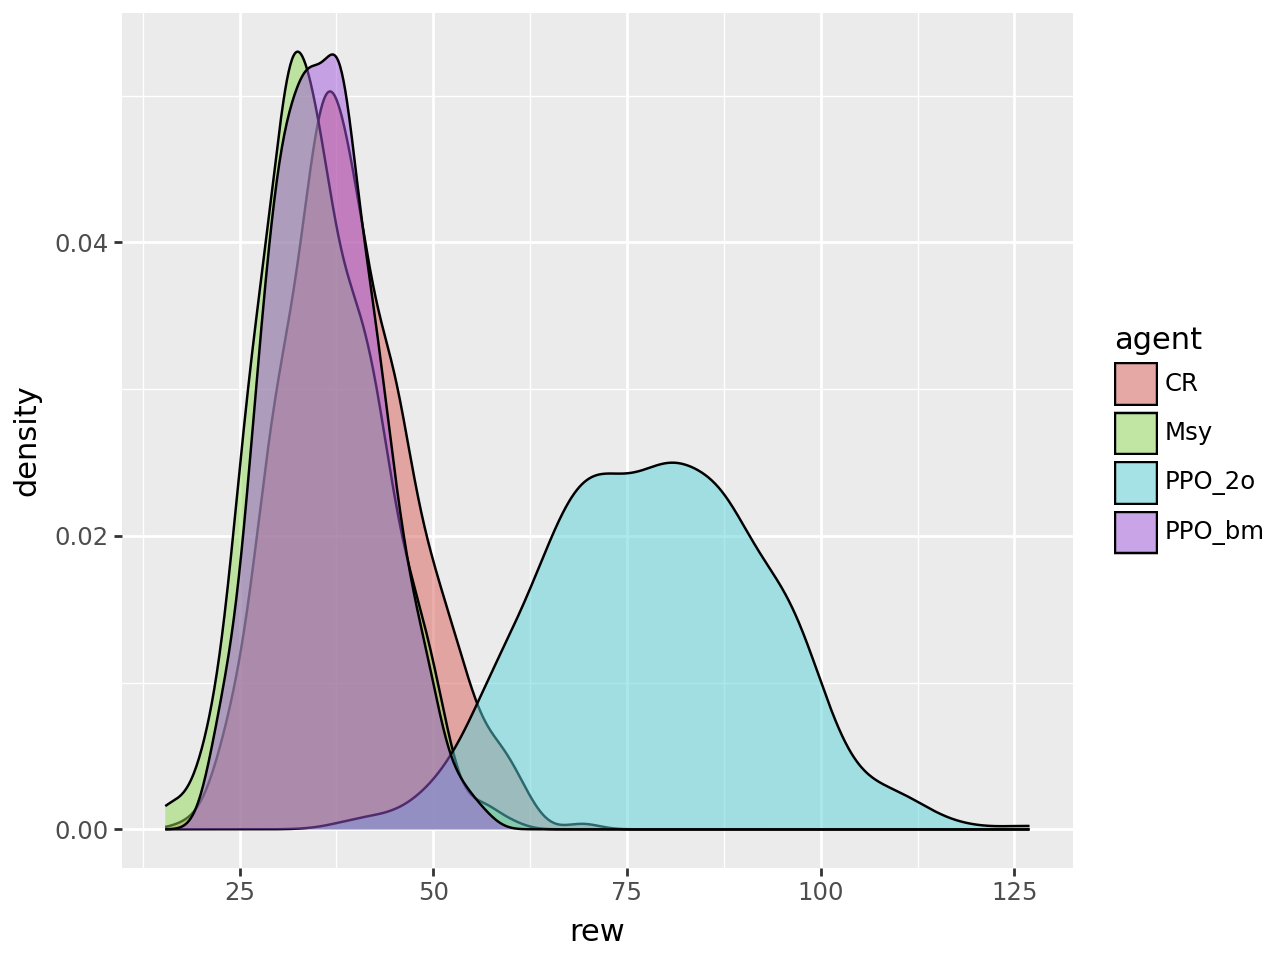

(<Figure Size: (640 x 480)>,)

In [24]:
(
    # ggplot(fixed_pol_df, aes(x='rew', fill='agent')) + geom_density(alpha=0.5),
    # ggplot(ppo_df, aes(x='rew', fill='agent')) + geom_density(alpha=0.5),
    ggplot(results_df, aes(x='rew', fill='agent')) + geom_density(alpha=0.5),
)